In [1]:
import pickle
import matplotlib.pyplot as plt
import os
os.chdir("/home/lucaserf/repositories/ObsProject/")
from docker_agent_logger.app.src.AI import *
import pandas as pd

2024-01-23 10:40:43.873126: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:40:44.124161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 10:40:44.124216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 10:40:44.172892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 10:40:44.274983: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 10:40:44.277289: I tensorflow/core/platform/cpu_feature_guard.cc:1

Using TensorFlow backend


In [76]:
!sshpass -p "lTLm#191" scp -r lucaserf@nodeserf2:/var/log/logging_data/ ./data/

Load key "/home/lucaserf/.ssh/wlslucaserf": Permission denied


In [77]:
df = pd.read_csv("data/logging_data/time.txt")


print(df.shape)


(8647, 8)


In [78]:
df.head()

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time
0,269k7,1,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
1,269k7,2,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
2,269k7,3,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
3,269k7,4,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09
4,269k7,5,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09


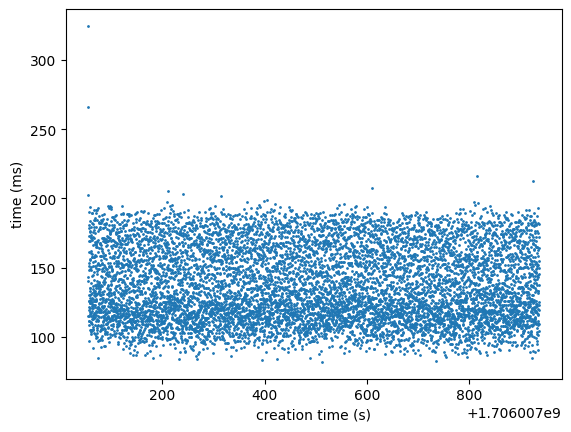

In [79]:
#get index and time for each id_node
fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node]
    index = node_df.log_creation_time.values
    time = (node_df.completion_time.values - node_df.log_creation_time.values)*1000 
    ax.scatter(index,time,s=1,zorder=1)
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')

plt.show()

In [71]:
df_vec1 = pd.read_csv("data/logging_data/time_vec1.txt")
df_vec2 = pd.read_csv("data/logging_data/time_vec2.txt")

df_vec1['x'] = df_vec1.log_creation_time.diff()
df_vec1[0] = 0

,id_node,id,type,log_creation_time,catch_time,after_preprocess_time,server_catch_time,completion_time,x
0,269k7,1,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,NaN
1,269k7,2,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,0.101607
2,269k7,3,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,0.101495
3,269k7,4,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,0.101822
4,269k7,5,vectorized_logs,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,1.706007e+09,0.102043


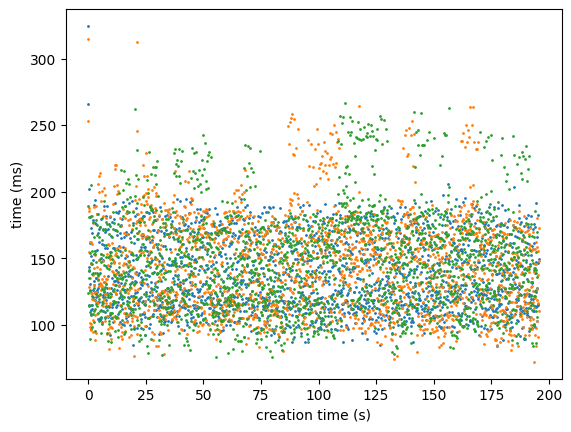

In [92]:
df_vec1 = pd.read_csv("data/logging_data/time_vec1.txt")
df_vec2 = pd.read_csv("data/logging_data/time_vec2.txt")
df_vec4 = pd.read_csv("data/logging_data/time_vec4.txt")

#merge dataframes adding a column indicating the parallelism
df_vec1['parallelism'] = 1
df_vec2['parallelism'] = 2
df_vec4['parallelism'] = 4

#get the shorter value between the dataframes
min_len = min(df_vec1.shape[0],df_vec2.shape[0]//df_vec2['parallelism'][0],df_vec4.shape[0]//df_vec4['parallelism'][0])
df = pd.concat([df_vec1[:min_len],df_vec2[:min_len*df_vec2['parallelism'][0]],df_vec4[:min_len*df_vec4['parallelism'][0]]])

fig, ax = plt.subplots()
for id_node in df.id_node.unique():
    node_df = df[df.id_node == id_node]
    x = node_df.log_creation_time.values - node_df.log_creation_time.values[0]
    y = (node_df.completion_time.values - node_df.log_creation_time.values)*1000 
    ax.scatter(x,y,s=1,zorder=1)
    
plt.xlabel('creation time (s)')
plt.ylabel('time (ms)')

plt.show()

In [ ]:
fig, ax = plt.subplots()
for key in ["logs"]:
    ax.plot(data[key], label=key)
    plt.xlabel('logs')
    plt.ylabel('size [Bytes]')
    plt.legend()

plt.show()

for key in ["mean_padding"]:
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()

In [ ]:
for key in data.keys():
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()
        # fig.savefig("")

In [9]:
#testing encoding and decoding
vocab_size = 4000
max_len=60
latent_dim = max_len//2

chkpt = "data_visualization/logging_data/logs_model/"

raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(1)
    .shuffle(buffer_size=256)
)

with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

ds = raw_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt)


# z = tf.random.normal(shape=(1, latent_dim))
# vectorized_token = ds.shuffle(buffer_size=256).take(1).as_numpy_iterator().next()

# print(tokenizer.decode(vectorized_token))

# z = model.vae.encode(vectorized_token)

# print(z)

# tokens = model.vae.decode(z)

# print(tokenizer.decode(tokens))



2023-11-14 15:24:32.273141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529400: I tensorflow/compile

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 60, 128)              519680    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 60, 128)              71828     ['input_embedding[0][0]']     
 er)                                                                                        

2023-11-14 15:25:03.546239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100000/100000 [==============================] - 2758s 27ms/step


2023-11-14 16:10:58.230430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13504693080879762698


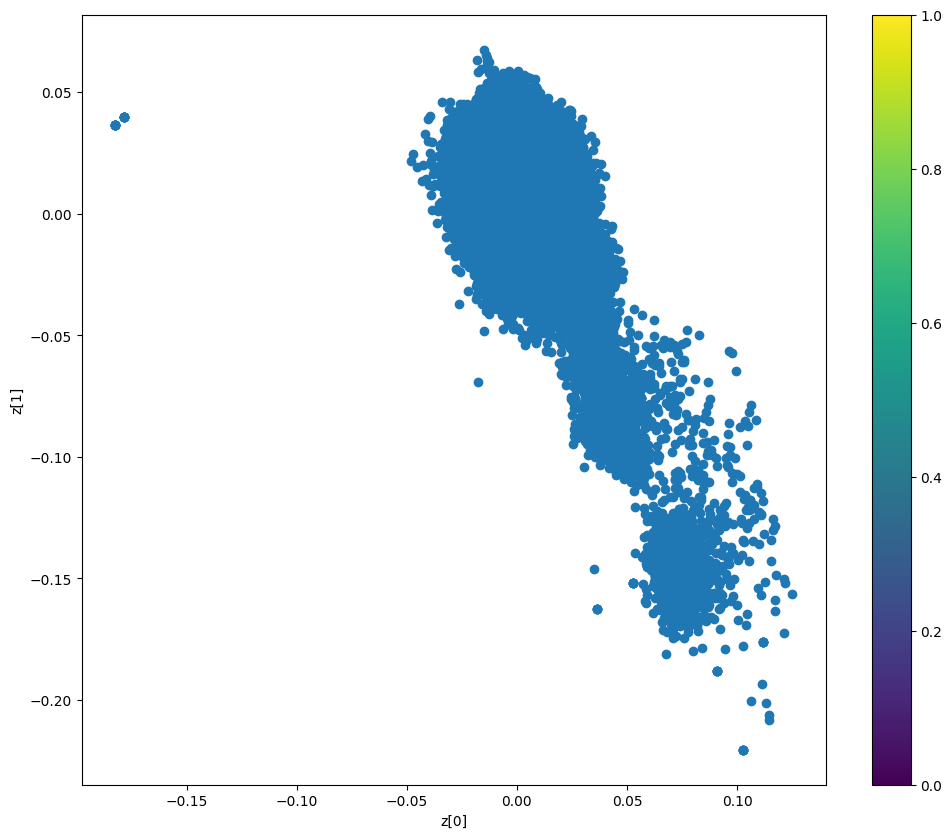

In [10]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

# model.vae.load_model(chkpt=chkpt)
plot_label_clusters(model.vae, "cluster",ds.take(100000))


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

In [49]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(64)
)

print(raw_ds.take(1).as_numpy_iterator().next())

[b'2015-12-03 14:37:47,611 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: STARTUP_MSG: '
 b'/************************************************************'
 b'STARTUP_MSG: Starting DataNode'
 b'STARTUP_MSG:   host = mesos-master-1/10.10.34.11'
 b'STARTUP_MSG:   args = []' b'STARTUP_MSG:   version = 2.7.1'
 b'STARTUP_MSG:   classpath = /usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/commons-digester-1.8.jar:/usr/local/hadoop/share/hadoop/common/lib/activation-1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-configuration-1.6.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-math3-3.1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/api-util-1.0.0-M20.jar:/usr/local/hadoop/share/hadoop/common/lib/hamcrest-core-1.3.jar:/usr/local/hadoop/share/hadoop/common/lib/jaxb-api-2.2.2.jar:/usr/local/hadoop/share/hadoop/common/lib/slf4j-api-1.7.10.jar:/usr/local/hadoop/share/hadoop/common/lib/jetty-util-6.1.26.jar:/usr/local/hadoop/share/hadoop/common/lib/jer